#### Import in-built modules

In [237]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn as skl
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

#### Identify the different folders for uploading and downloading

In [238]:
import sys
import os

project_path = os.path.abspath(os.path.join('..\..'))
data_input_path = project_path+"\\data\\inputs"
module_path = project_path+"\\src\\modules"
print(project_path)
print(data_input_path)
print(module_path)

D:\personal_projects\BooksRatingPrediction
D:\personal_projects\BooksRatingPrediction\data\inputs
D:\personal_projects\BooksRatingPrediction\src\modules


#### Import the created modules

In [239]:
# Add the module folder to the system path
if module_path not in sys.path:
    sys.path.append(module_path)

# Import the created functions
%reload_ext autoreload 
%autoreload all # to automatically reload a module when it has been modified

# 1 - For data preparation
from data_prep_fcns import get_genre_by_isbn, create_batch
# 2 - For EDA
from eda_fcns import ratings_to_appreciation, getyear, get_num_occ_genre, is_top_genre, get_num_occ_authors, get_num_occ_title
# 3 - For feature selection
from feat_selec_fcns import make_mi_scores

#### Load the dataset and give it a first glance

In [240]:
# some lines from the initial 'books.csv' were cleaned because the separator couldn't work (ex: 3350, 4704, 5879, 8981)
books_df = pd.read_csv(data_input_path+'\\books.csv',sep=',')
books_df.head(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [241]:
books_df.tail(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
11122,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press
11123,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books
11124,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books
11125,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco
11126,45641,Las aventuras de Tom Sawyer,Mark Twain,3.91,8497646983,9788497646987,spa,272,113,12,5/28/2006,Edimat Libros


# A - Data preparation

In [242]:
books_df.isnull().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

In [243]:
books_df.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

In [244]:
books_df.duplicated().any()

False

The original dataset is clean. So we can go on with the feature engineering

In [245]:
raw_books_df = books_df.copy() # to get a copy of the initial data frame without re-loading the csv file

We integrate the "genre" as a feature to assess its relevance

In [246]:
# CHOICE OF THE FETCH METHOD
# ---------------------------
# choice 1: The output vector doesn't exist and we retrieve the genre with the google API 
# In the worst case scenario, it achieves the task in 5h because of the time rate limiter put on the API queries
# This can be however bettered by :
# - creating a google account
# - creating an user ID for the API and 
# - ask to Google to increase the number of queries per day and per minute 
# In this case, you can increase the number of elements in a single batch for fast processing

# choice 2: The choice 1 was already launched and the result was saved in a csv file. 
# Now, we just load this file and retrieve the genres

choice = 2 

# Instatiate the output vector containing the genre as an empty list.
genrevec = []
if choice == 1 : 
    # 1 - get the vector column of ibsn 
    isbnvec = books_df['isbn']
    num_batch_el = 50

    # 2 - split the vector column of ibsn into batches
    isbnvec_batch = create_batch(isbnvec, num_batch_el) 

    # 3 - Get the genre by respecting API requests quota :
    start = time.time()
    N = len(isbnvec_batch)
    count = 0

    print('Number of batches to process:', N)
    for i in range(N) :
    #   a - get the current time at the start of the batch processing
        startTime = time.time()

    #   b - get the genre for each element of the batch and append it in the output vector list
        batch = isbnvec_batch[i]
        for j in range(len(batch)):
            isbn_selected = batch[j]
            genre = get_genre_by_isbn(isbn_selected)
            genrevec.append(genre)
            count+=1
        batch = []

    #   c - get the elapsed time
        elapsedTime = time.time() - startTime 
        durationTime = time.time() - start
        print('Batch N° '+ str(i+1) + '  runtime : ' + str(round(elapsedTime,1)) + ' s' + 
              '\nElapsed time since start : ' + str(round(durationTime,1)) + ' s')

    #   d - wait for the remaining time before processing to the next batch
        time.sleep(60 - elapsedTime)

    print('Total time : ' + str(time.time() - start) + ' s')
    
    # 4 - Save the result in a csv file
    np.savetxt("genres.csv", genrevec, delimiter =", ", fmt ='% s')
    
else :
    import csv
    with open(data_input_path+'\\genres.csv', encoding='Windows-1252', newline='') as inputfile:
        for row in csv.reader(inputfile):
            genrevec.append(row[0])

# Print a part of the vec to verify if the process went well
print(genrevec[0:49])

['nan', 'nan', 'Juvenile Fiction', 'Juvenile Fiction', 'Juvenile Fiction', 'Fiction', 'England', 'Fiction', 'Fiction', 'Fiction', 'nan', 'Fiction', 'Science', 'Biography & Autobiography', 'Language Arts & Disciplines', 'True Crime', 'Biography & Autobiography', 'Travel', 'Travel', 'Travel', 'Language Arts & Disciplines', 'Fiction', 'Fiction', 'Fantasy fiction', 'Fantasy fiction', 'Literary Criticism', 'Fiction', 'Computers', 'nan', 'Education', 'Authors', 'Music', 'Literary Criticism', 'Fiction', 'Juvenile Fiction', 'Juvenile Fiction', 'nan', 'Fiction', 'Fiction', 'Fiction', 'nan', 'Fiction', 'Business & Economics', 'Games', 'nan', 'Literary Collections', 'Biography & Autobiography', 'Nature', 'Science']


In [247]:
# Add the genres to our data set
books_df['genre'] = genrevec
books_df.head(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,genre
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,nan
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,nan
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,Juvenile Fiction
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,Juvenile Fiction
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,Juvenile Fiction


In [248]:
100*len(books_df[books_df['genre']=='nan'])/len(books_df)

7.863754830592253

In [249]:
# 8% of our data have missing genres. So it's reasonable to discard them
books_df.drop(books_df[books_df['genre']=='nan'].index, inplace = True)

In [250]:
# Add new features that will take into account the occurence of title and genre. The reason is to think the more a title 
# an author or a genre appears in a list, the more it is liked by the audience, implying possibly better reviews 
books_df['num_occ_title'] = books_df.groupby('title')['title'].transform('count') 
books_df['num_occ_authors'] = books_df.groupby('authors')['authors'].transform('count') 
books_df['num_occ_genre'] = books_df.groupby('genre')['genre'].transform('count') 
books_df['num_authors']=[len(el.split('/')) for el in books_df.authors]
books_df['num_publishers']=[len(el.split('/')) for el in books_df.publisher]

In [251]:
books_df.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
num_pages               int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
genre                  object
num_occ_title           int64
num_occ_authors         int64
num_occ_genre           int64
num_authors             int64
num_publishers          int64
dtype: object

# B - Exploratory Data Analysis

In [252]:
books_df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count,num_occ_title,num_occ_authors,num_occ_genre,num_authors,num_publishers
count,10252.000000,10252.000000,1.025200e+04,10252.000000,1.025200e+04,10252.000000,10252.000000,10252.000000,10252.000000,10252.000000,10252.000000
mean,21438.162407,3.929190,9.758049e+12,343.156945,1.786388e+04,546.387924,1.194304,4.423332,1742.108076,1.724639,1.011803
std,13114.466010,0.349405,4.613648e+11,236.601251,1.106223e+05,2565.106075,0.744305,6.076824,1851.500501,1.847246,0.115846
min,4.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,10371.500000,3.770000,9.780345e+12,204.000000,1.290000e+02,10.000000,1.000000,1.000000,95.000000,1.000000,1.000000
50%,20557.000000,3.950000,9.780554e+12,304.000000,8.460000e+02,52.000000,1.000000,2.000000,587.000000,1.000000,1.000000
75%,32282.250000,4.130000,9.780831e+12,416.000000,5.312500e+03,251.000000,1.000000,6.000000,4027.000000,2.000000,1.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000,8.000000,35.000000,4027.000000,51.000000,4.000000


## B1 - Numerical variables

### 1- Average rating

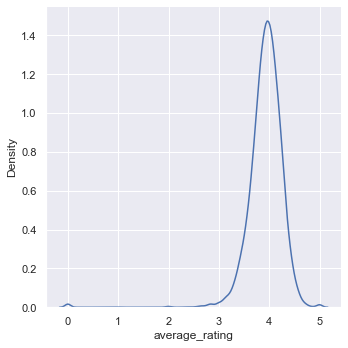

In [253]:
# Distribution of Average rating 
sns.displot(data = books_df, x = 'average_rating', kind = 'kde')

The distribution is right and the data are normally distributed, with most of the data having average rating around 4 stars. This implies that our data may be biased by well-rated books since there is not an equal distribution of average rating.
Let's now create a categorical feature according to the average rating

In [254]:
# Add a convenient feature : appreciation of ratings
books_df['appreciation'] = books_df.average_rating.apply(ratings_to_appreciation)

[5664 4509   79]


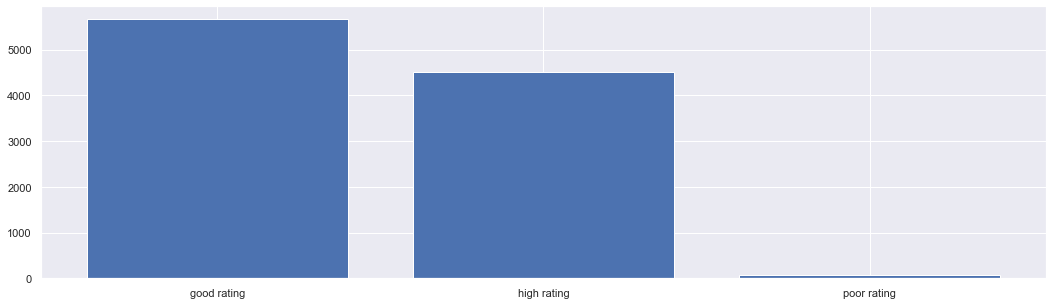

In [255]:
# Distribution in percentage of the qualitative rating
plt.bar(books_df.appreciation.value_counts().index, 
        books_df.appreciation.value_counts().values)
print(books_df.appreciation.value_counts().values)

To harmonize the average rating, let's see the effect of weighting on the average rating. In fact, the idea is to take into account the ratings count in the average rating so that the book with higher ratings count will their average ratings better acknowledged compared to a book with the same average rating but with lower ratings

In [256]:
def weighted_rating(df, m, C):
    v = df['ratings_count']
    R = df['average_rating']
    
    return (v*R + m*C)/(m+v) 

In [257]:
C = books_df['average_rating'].mean()
m = books_df['ratings_count'].quantile(0.85)

ratings_afr_weighting = weighted_rating(books_df, m,  C)

print('Mean of the average ratings : ' , C)
print('Minimum votes required : ', m)

books_df['weighted_average_rating'] = ratings_afr_weighting
ratings_bfr_weighting = books_df['average_rating']
books_df

Mean of the average ratings :  3.929190401872786
Minimum votes required :  13499.0


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,genre,num_occ_title,num_occ_authors,num_occ_genre,num_authors,num_publishers,appreciation,weighted_average_rating
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,Juvenile Fiction,2,9,850,1,1,high rating,4.085922
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,Juvenile Fiction,2,4,850,2,1,high rating,4.556381
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,Juvenile Fiction,1,4,850,2,1,high rating,4.570903
5,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books,Fiction,1,1,4027,1,1,good rating,3.928924
6,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic,England,1,9,21,1,1,high rating,4.471019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press,Fiction,1,1,4027,3,1,high rating,3.930685
11123,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books,Fiction,1,5,4027,1,1,high rating,3.937458
11124,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books,Fiction,1,5,4027,1,1,good rating,3.930955
11125,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco,Social Science,1,5,95,1,1,good rating,3.917916


(0.11766189157431453, 6.216568670685241e-33)
(0.03374739380200251, 0.0006318672819948756)


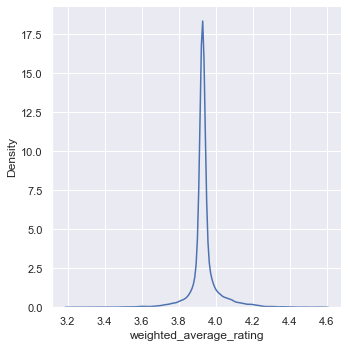

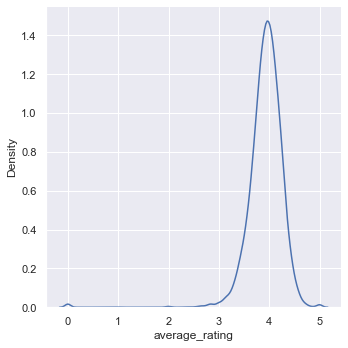

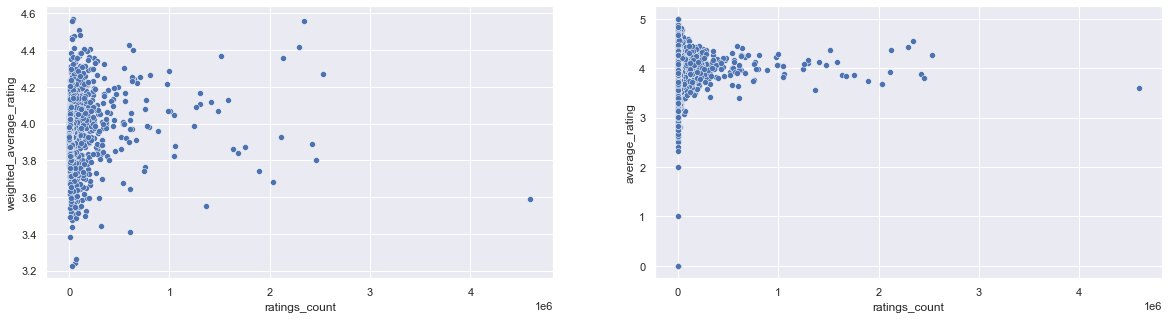

In [258]:
sns.displot(data = books_df, x='weighted_average_rating', kind = 'kde')
sns.displot(data = books_df, x='average_rating', kind = 'kde')

x = books_df.ratings_count
y1 = books_df.weighted_average_rating
y2 = books_df.average_rating

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.scatterplot(x = x, y = y1, ax = axes[0])
sns.scatterplot(x = x, y = y2, ax = axes[1])

from scipy.stats.stats import pearsonr
#calculation correlation coefficient and p-value between x and y
print(pearsonr(x, y1))
print(pearsonr(x, y2))

As we can observe, applying the weighting increases extremely the concentration of average ratings , thus the bias on our response variable which is not good. So we will drop it 

In [259]:
books_df.drop('weighted_average_rating', axis = 1, inplace = True)
books_df

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,genre,num_occ_title,num_occ_authors,num_occ_genre,num_authors,num_publishers,appreciation
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,Juvenile Fiction,2,9,850,1,1,high rating
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,Juvenile Fiction,2,4,850,2,1,high rating
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,Juvenile Fiction,1,4,850,2,1,high rating
5,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books,Fiction,1,1,4027,1,1,good rating
6,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic,England,1,9,21,1,1,high rating
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press,Fiction,1,1,4027,3,1,high rating
11123,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books,Fiction,1,5,4027,1,1,high rating
11124,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books,Fiction,1,5,4027,1,1,good rating
11125,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco,Social Science,1,5,95,1,1,good rating


To emphasize on what we saw above, Most of the books (99%) have either good ratings or high ratings. So before training our model, we will get rid of the books having poor ratings

In [260]:
remove_outliers_average_rating = books_df.average_rating >= 3

## 2 - number of pages

<AxesSubplot:xlabel='num_pages'>

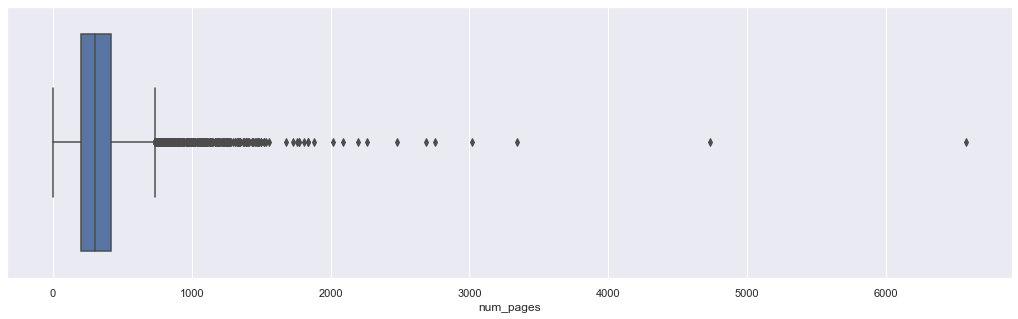

In [261]:
sns.boxplot(books_df.num_pages)

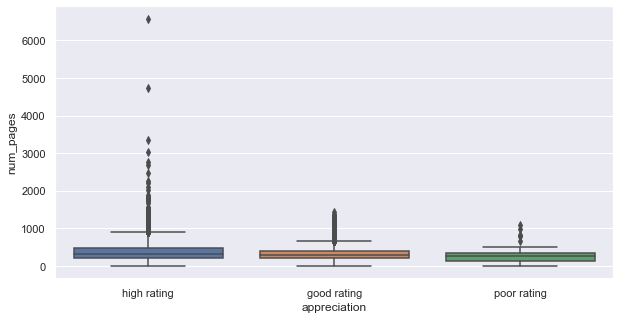

In [262]:
plt.figure(figsize=(10,5))
sns.boxplot(x=books_df.appreciation,y=books_df.num_pages)
plt.show()

There is a little correlation between the number of pages and the appreciation. In fact, the better the ratings, the higher the number of pages. Beware of the outliers present above 1000 pages. We will get rid of them during the preprocessing.

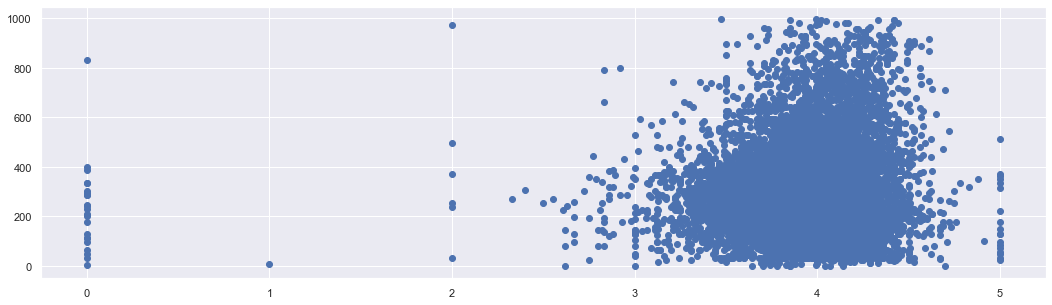

In [263]:
remove_outliers_numpages = books_df.num_pages < 1000
plt.scatter(books_df.average_rating[remove_outliers_numpages], books_df.num_pages[remove_outliers_numpages])

HOwever, the correlation described above is not visible on the scatter plot

### 3 - Ratings count & text reviews count

<AxesSubplot:xlabel='ratings_count'>

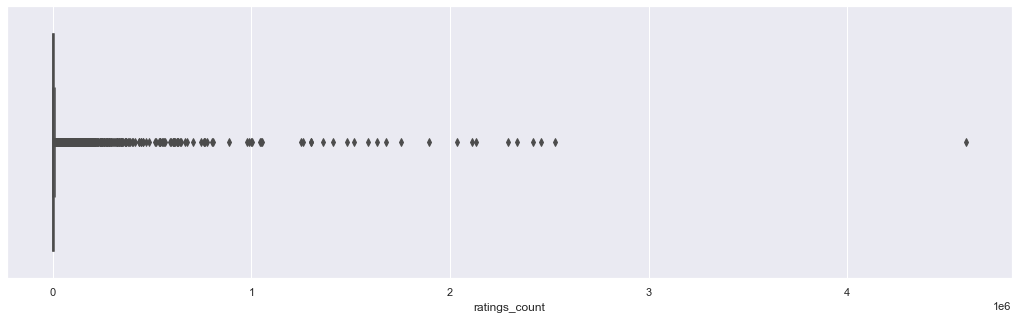

In [264]:
sns.boxplot(books_df.ratings_count)

<AxesSubplot:xlabel='text_reviews_count'>

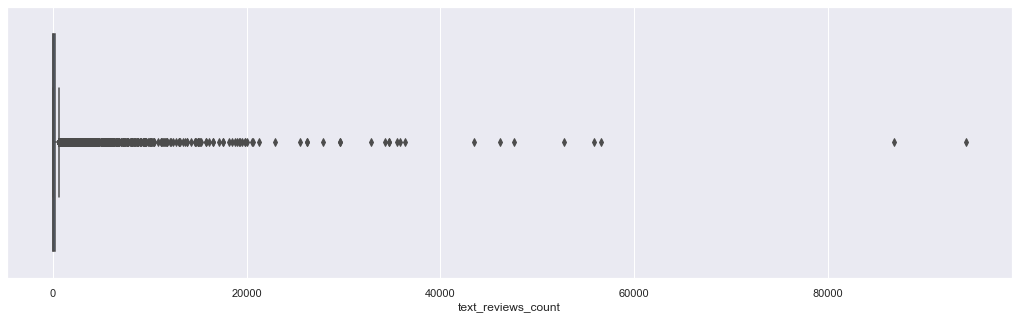

In [265]:
sns.boxplot(books_df.text_reviews_count)

Some outliers are present for the features above. We will get rid of them during the preprocessing

In [266]:
remove_outliers_counts = (books_df.ratings_count<1000000) & (books_df.text_reviews_count <20000)

(0.861517886946991, 0.0)


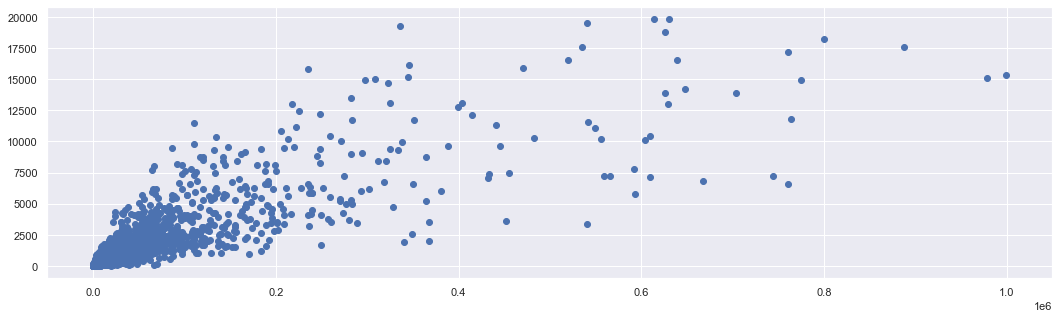

In [267]:
x = books_df.ratings_count[remove_outliers_counts]
y = books_df.text_reviews_count[remove_outliers_counts]

plt.scatter(x, y)

from scipy.stats.stats import pearsonr

#calculation correlation coefficient and p-value between x and y
print(pearsonr(x, y))

The rating counts and text reviews count are highly correlated

<AxesSubplot:xlabel='average_rating', ylabel='ratings_count'>

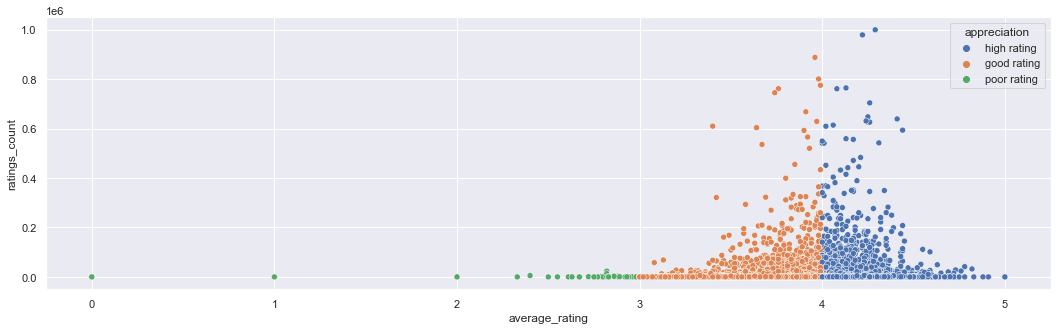

In [268]:
sns.scatterplot(data=books_df[remove_outliers_counts], y="ratings_count", x='average_rating', hue="appreciation")

Overall, the ratings count follows a normal distribution with respect to the average ratings with the mean being around 4. It looks like books having high and good ratings have higher number of ratings count than books with poor ratings. However, it is hard to get a sense of correlation comparing just between high-ratings books and good-ratings ones.

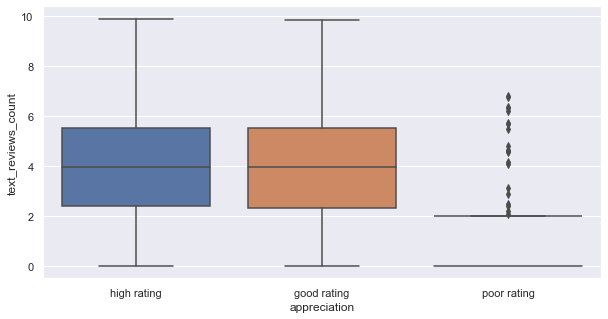

In [269]:
# Since the number of counts are pretty high, we will apply a log transformation to better visualize the relationships 
# between the counts and the average rating

y = np.log(books_df.text_reviews_count[remove_outliers_counts])
x = books_df[remove_outliers_counts].appreciation


plt.figure(figsize=(10,5))
sns.boxplot(x=x,y=y)
plt.show()

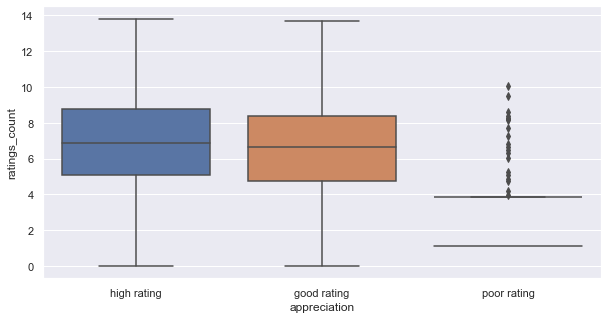

In [270]:
y = np.log(books_df.ratings_count[remove_outliers_counts])
x = books_df.appreciation[remove_outliers_counts]

plt.figure(figsize=(10,5))
sns.boxplot(x=x,y=y)
plt.show()

It seems finally that books with high ratings have higher ratings counts than books with good ratings.

### 4 - Publication date

In [271]:
books_df['publication_year'] = books_df.publication_date.apply(getyear)

Publication year range:  [1900, 2020]


<AxesSubplot:xlabel='publication_year', ylabel='average_rating'>

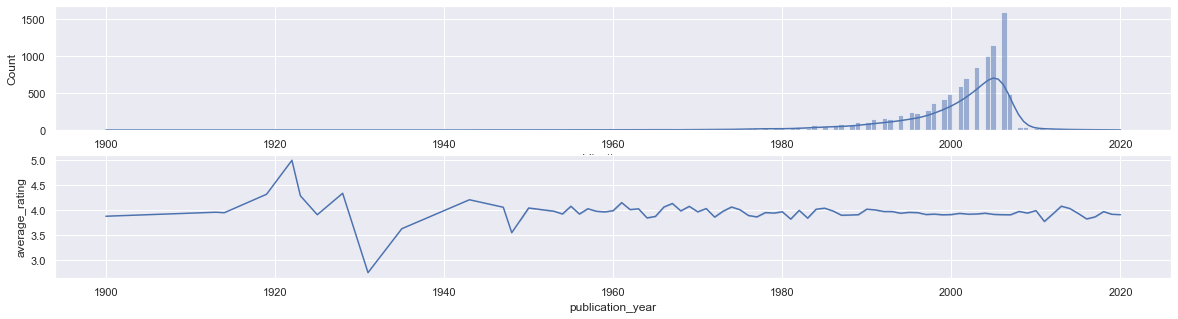

In [272]:
pub_date_range = [books_df['publication_year'].min(),books_df['publication_year'].max()]
print('Publication year range: ', str(pub_date_range))

y = books_df.groupby('publication_year')['average_rating'].transform('mean') 

fig, axes = plt.subplots(2, 1, figsize=(20, 5))

sns.histplot(books_df, x = 'publication_year', kde = True,ax=axes[0])
sns.lineplot(x=books_df['publication_year'],y=y, ax=axes[1])

It seems there is no correlation between the average rating and the publication year. It's still difficult to compare since the counts before before 1960 is not comparable to the counts after that year.

### 5 - Occurences of title, publishers, authors and genre

In [273]:
num_occ_list = ['num_occ_title','num_occ_authors','num_occ_genre','average_rating']
num_list = ['num_authors','num_publishers','average_rating']

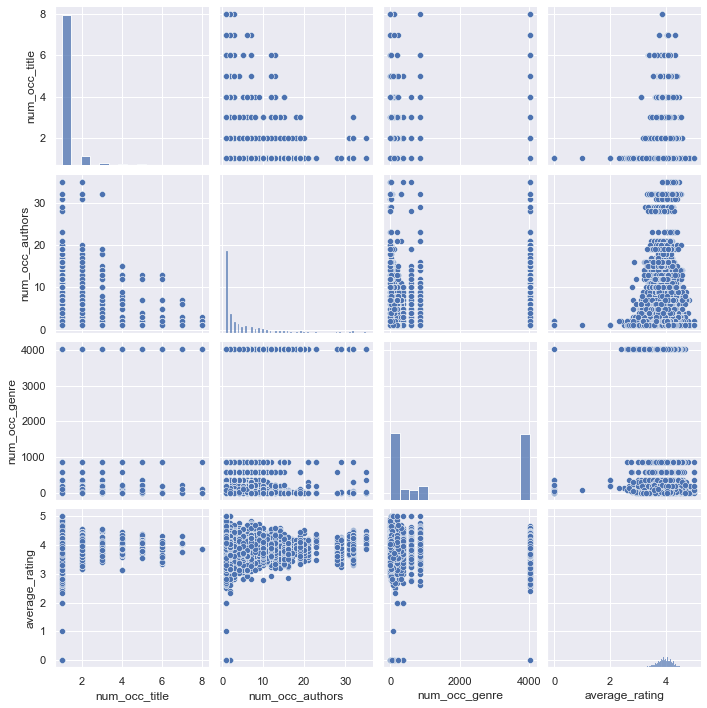

In [274]:
sns.pairplot(books_df[num_occ_list])

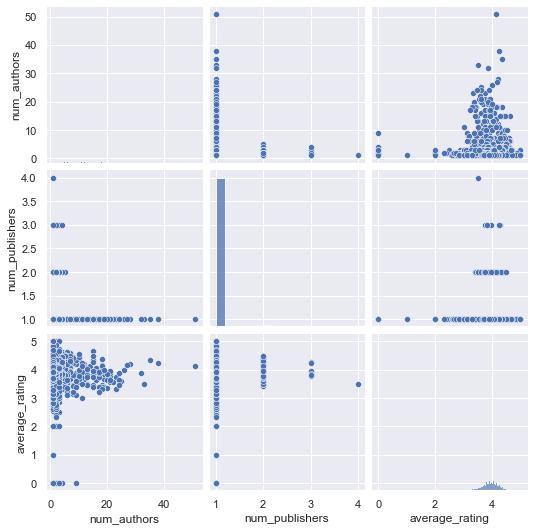

In [275]:
sns.pairplot(books_df[num_list])

Most of the features are right-skewed except for the number of occurences of a genre which is irregularly distributed. We can also add that the books having good ratings or high ratings have in general a higher number of occurence of authors and number of occurence of a genre 

<AxesSubplot:xlabel='appreciation', ylabel='num_occ_genre'>

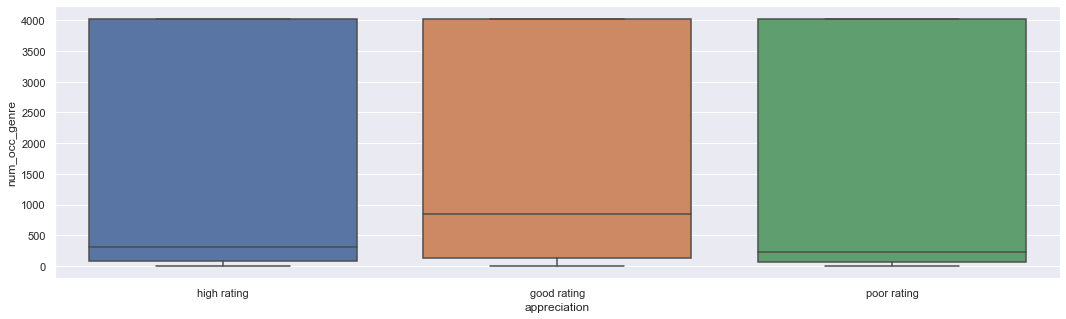

In [276]:
x = books_df.appreciation
y = books_df.num_occ_genre
sns.boxplot(x=x,y=y)

<AxesSubplot:xlabel='appreciation', ylabel='num_occ_authors'>

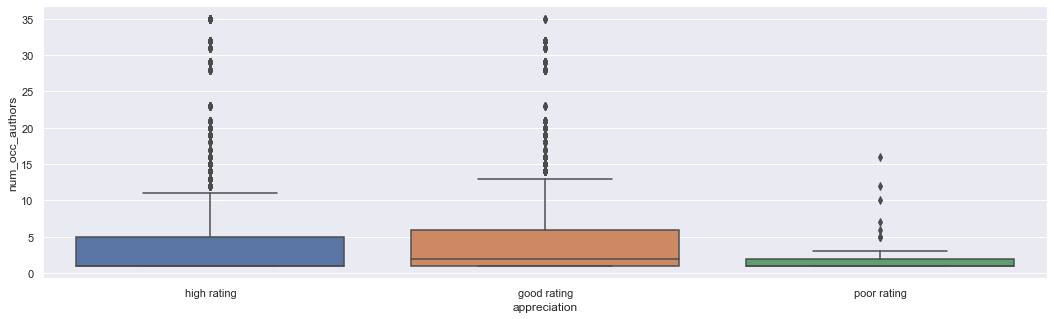

In [277]:
x = books_df.appreciation
y = books_df.num_occ_authors
sns.boxplot(x=x,y=y)

<AxesSubplot:xlabel='appreciation', ylabel='num_occ_title'>

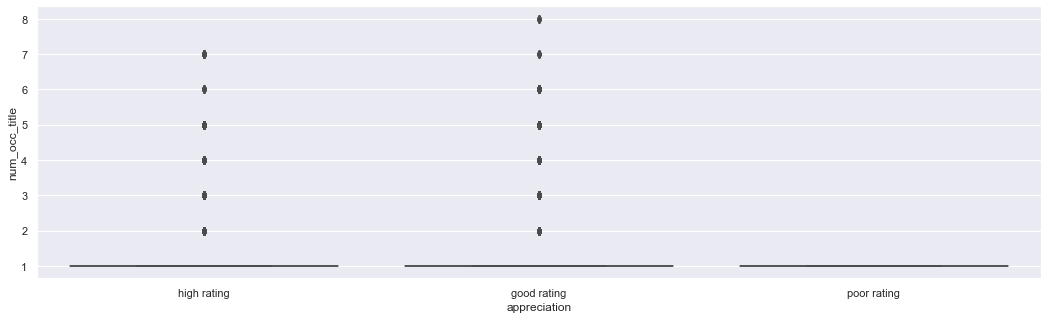

In [278]:
x = books_df.appreciation
y = books_df.num_occ_title
sns.boxplot(x=x,y=y)

## B2 - Categorical variables

### 1 - Language

In [279]:
print(books_df.language_code.unique())

['eng' 'en-US' 'spa' 'en-GB' 'mul' 'fre' 'grc' 'enm' 'en-CA' 'jpn' 'ger'
 'ara' 'zho' 'lat' 'por' 'rus' 'msa' 'glg' 'wel' 'ita' 'swe' 'nor' 'ale']


<AxesSubplot:xlabel='language_code', ylabel='Count'>

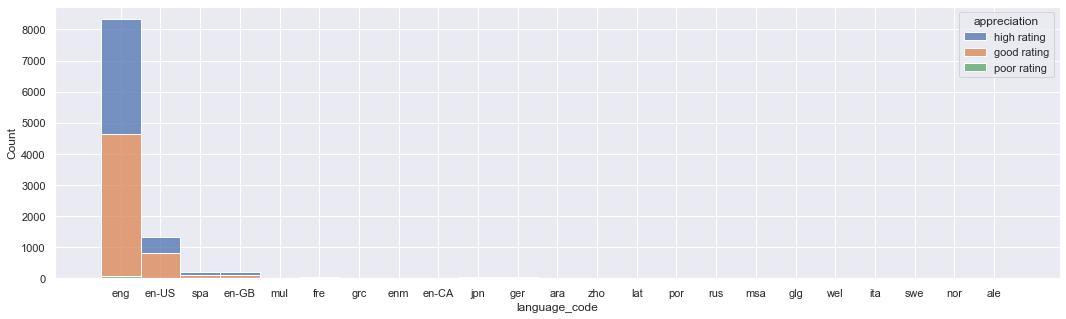

In [280]:
sns.set(rc={'figure.figsize':(18,5)})
sns.histplot(x='language_code',hue='appreciation',multiple='stack', data  = books_df)

<AxesSubplot:xlabel='language_code', ylabel='Count'>

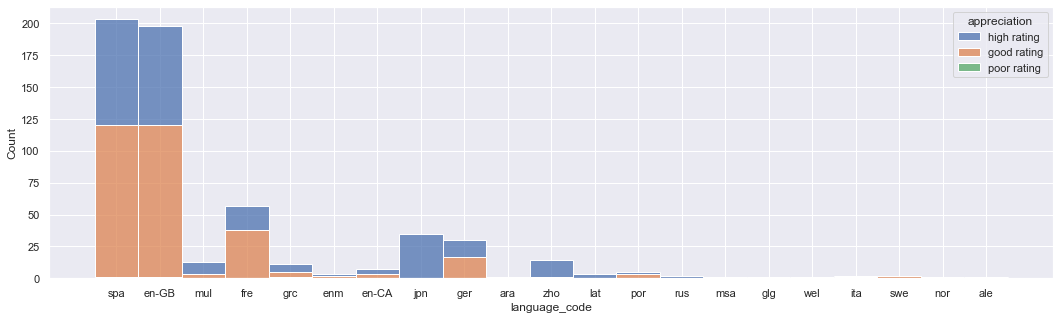

In [281]:
list_language = ['eng', 'en-US']
books_df_llr = books_df[books_df.language_code.apply(lambda x: x not in list_language)] # list of books that language is least represented
sns.histplot(x='language_code',hue='appreciation',multiple='stack', data  = books_df_llr)

Most of the books from the dataset are written in International English and US English. Moreover, they are the ones with the "good" and high ratings. What about the other languages ?

In [282]:
percentage_llr = 100*(len(books_df_llr) / len(books_df))
print('Percentage of books with the least represented languages :' + str(round(percentage_llr,1)) + '%')

Percentage of books with the least represented languages :5.8%


In [283]:
eng_language = ['eng', 'en-US','en-GB']
books_df_eng_all = books_df[books_df.language_code.apply(lambda x: x in eng_language)]
books_df_eng_std = books_df[books_df.language_code == 'eng']
percentage_eng_all = 100*(len(books_df_eng_all) / len(books_df))
percentage_eng_std = 100*(len(books_df_eng_std) / len(books_df))
print('Percentage of English-written books :' + str(round(percentage_eng_all,1)) + '%')
print('Percentage of International English-written books :' + str(round(percentage_eng_std,1)) + '%')

Percentage of English-written books :96.2%
Percentage of International English-written books :81.2%


Another bias due to the nature of our dataset comes from the language. In fact, most of the books are written in International English, followed by american English. This implies that our model won't be accurate in assessing ratings of book written in languages other than the aforementioned one

### 2 - Authors, publisher and genre

In [284]:
books_df.groupby('genre')['genre'].count().sort_values().tail(10)
len(books_df)

10252

In [285]:
goodbooks = books_df[books_df['average_rating'] >= 3]
badbooks = books_df[books_df['average_rating'] < 3]

In [286]:
best_authors = goodbooks.groupby('authors')['authors'].count().sort_values().tail(10)
worst_authors = badbooks.groupby('authors')['authors'].count().sort_values(ascending=False).head(10)

best_publishers = goodbooks.groupby('publisher')['publisher'].count().sort_values().tail(10)
worst_publishers = badbooks.groupby('publisher')['publisher'].count().sort_values(ascending=False).head(10)

best_genres = goodbooks.groupby('genre')['genre'].count().sort_values().tail(10)
worst_genres = badbooks.groupby('genre')['genre'].count().sort_values(ascending=False).head(10)

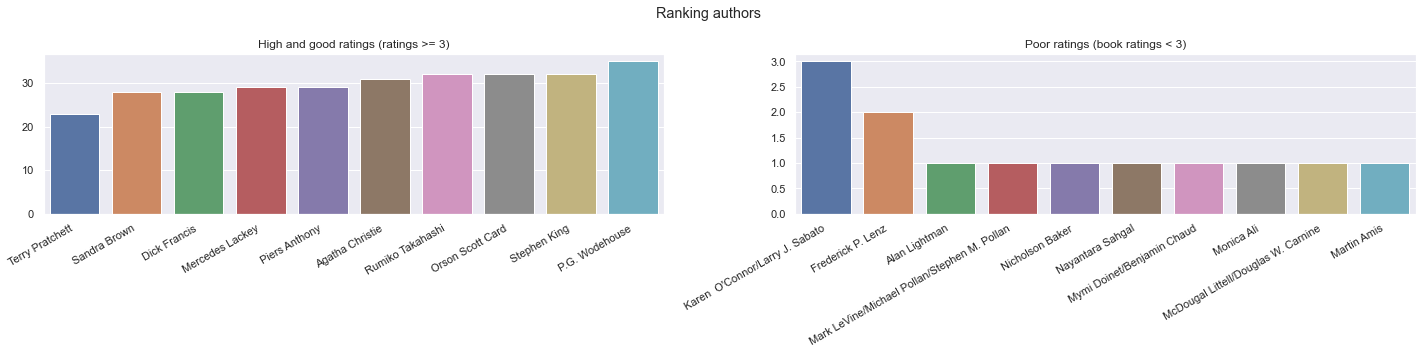

In [287]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Ranking authors')

# Best authors
sns.barplot(ax=axes[0], x=best_authors.index, y=best_authors.values)
plt.setp(axes[0].get_xticklabels(), rotation=30, ha='right')
axes[0].set_title("High and good ratings (ratings >= 3)")
axes[0].set(xlabel=None)

# Worst authors
sns.barplot(ax=axes[1], x=worst_authors.index, y=worst_authors.values)
plt.setp(axes[1].get_xticklabels(), rotation=30, ha='right')
axes[1].set_title("Poor ratings (book ratings < 3)")
axes[1].set(xlabel=None)

fig.tight_layout()

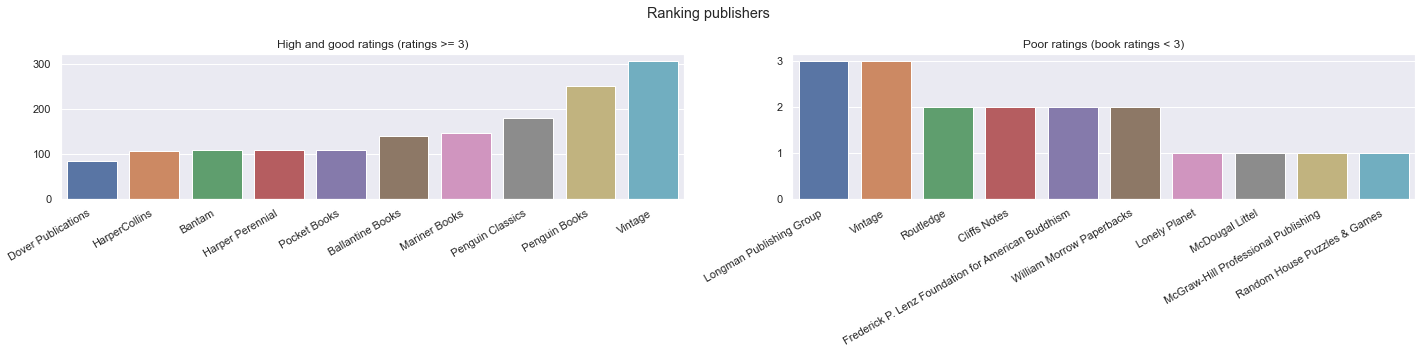

In [288]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Ranking publishers')

# Best genres
sns.barplot(ax=axes[0], x=best_publishers.index, y=best_publishers.values)
plt.setp(axes[0].get_xticklabels(), rotation=30, ha='right')
axes[0].set_title("High and good ratings (ratings >= 3)")
axes[0].set(xlabel=None)

# Worst genres
sns.barplot(ax=axes[1], x=worst_publishers.index, y=worst_publishers.values)
plt.setp(axes[1].get_xticklabels(), rotation=30, ha='right')
axes[1].set_title("Poor ratings (book ratings < 3)")
axes[1].set(xlabel=None)

fig.tight_layout()

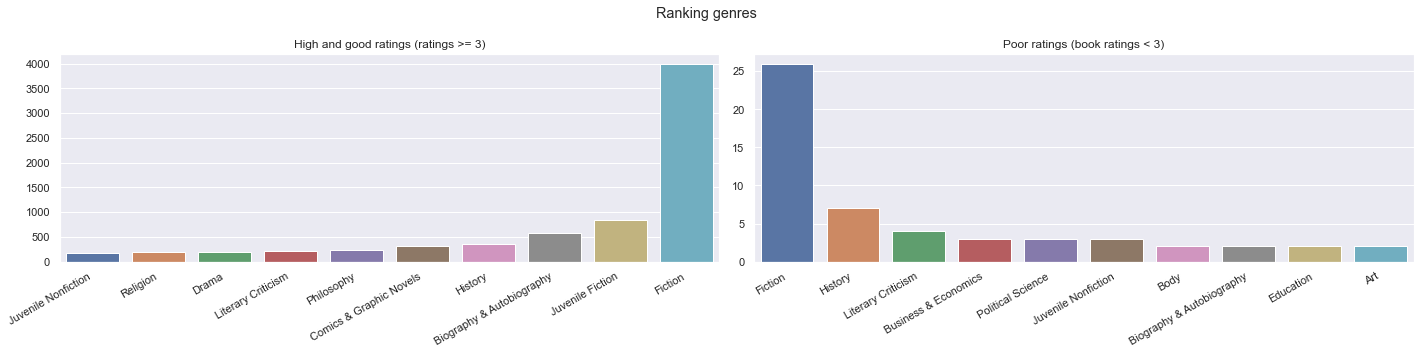

In [289]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Ranking genres')

# Best genres
sns.barplot(ax=axes[0], x=best_genres.index, y=best_genres.values)
plt.setp(axes[0].get_xticklabels(), rotation=30, ha='right')
axes[0].set_title("High and good ratings (ratings >= 3)")
axes[0].set(xlabel=None)

# Worst genres
sns.barplot(ax=axes[1], x=worst_genres.index, y=worst_genres.values)
plt.setp(axes[1].get_xticklabels(), rotation=30, ha='right')
axes[1].set_title("Poor ratings (book ratings < 3)")
axes[1].set(xlabel=None)

fig.tight_layout()

#nan values stands for the genre we couldn't retrieve

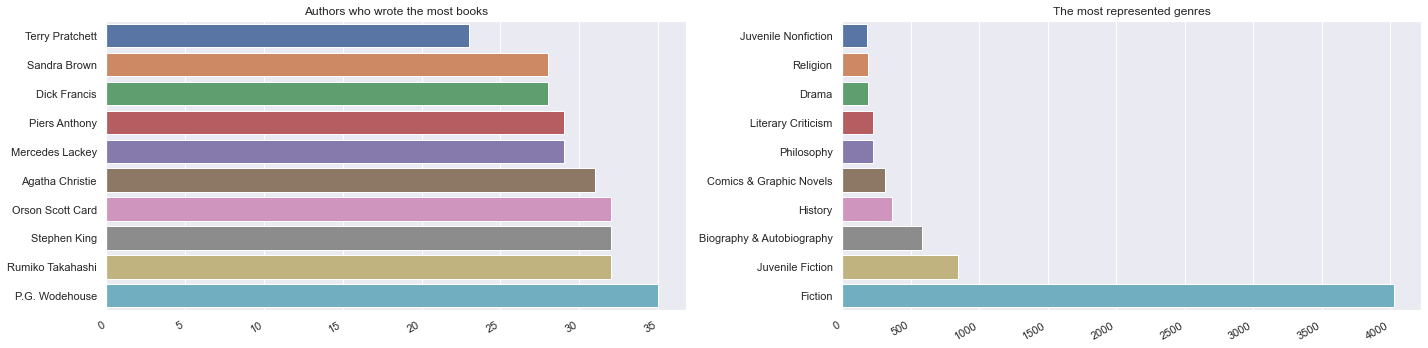

In [290]:
# Get the authors who wrote the most books and the most represented genres
mostauthors = books_df.groupby('authors')['authors'].count().sort_values().tail(10)
mostgenres = books_df.groupby('genre')['genre'].count().sort_values().tail(10)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
#fig.suptitle('Ranking genres')

# Best genres
sns.barplot(ax=axes[0], x=mostauthors.values, y=mostauthors.index)
plt.setp(axes[0].get_xticklabels(), rotation=30, ha='right')
axes[0].set_title("Authors who wrote the most books")
axes[0].set(ylabel=None)

# Worst genres
sns.barplot(ax=axes[1], x=mostgenres.values, y=mostgenres.index)
plt.setp(axes[1].get_xticklabels(), rotation=30, ha='right')
axes[1].set_title("The most represented genres")
axes[1].set(ylabel=None)

fig.tight_layout()

On an absolute point of view, we know the best genres, authors and publishers. However, one of the drawbacks is that the values for each feature subcategory are meaningless if the sub-category itself is also over-represented (ex: fiction & juvenile fiction in genre feature or PG Wodehouse & Stephen King in author). A way to sort out is to look at the problem on relative view ie to calculate the proportion of highly-rated features according to its total count.    

It should be noted that the absolute viewpoint doesn't invalidate the selection of the selection of features according to the high/low ratings ranking but rather the ranking itself. In fact, a genre is still among the best but if it is N°1 on an absolute viewpoint, it could be N°5 on a relative viewpoint

# C - Feature selection

Let's preprocess our dataset before the training :  
1- Drop the outliers (on appreciation, number of pages,  text reviews and ratings count)     
2- Drop the other non-numerical columns except for the genre         
3- Drop the publication date column

In [291]:
books_df_processed = books_df.copy()
print(books_df_processed.columns)
print(books_df_processed.shape)

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher', 'genre', 'num_occ_title',
       'num_occ_authors', 'num_occ_genre', 'num_authors', 'num_publishers',
       'appreciation', 'publication_year'],
      dtype='object')
(10252, 20)


In [292]:
# Drop the unecessary categorical columns 
drop_list = ['bookID', 'title', 'authors', 'isbn', 'isbn13','publisher','publication_date']

books_df_processed.drop(drop_list, axis=1, inplace=True)
print(books_df_processed.columns)

Index(['average_rating', 'language_code', 'num_pages', 'ratings_count',
       'text_reviews_count', 'genre', 'num_occ_title', 'num_occ_authors',
       'num_occ_genre', 'num_authors', 'num_publishers', 'appreciation',
       'publication_year'],
      dtype='object')


In [293]:
# Remove outliers
remove_outliers = remove_outliers_average_rating & remove_outliers_counts & remove_outliers_numpages
books_df_processed = books_df_processed[remove_outliers]
books_df_processed.shape

(9944, 13)

<AxesSubplot:xlabel='average_rating'>

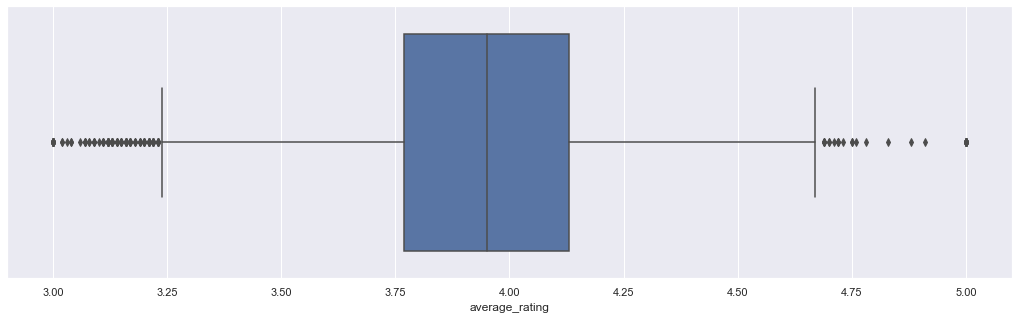

In [294]:
sns.boxplot(books_df_processed.average_rating)

The dataset still contains enough data and we improve distribution of the average rating in the meantime. Now let's transform our columns *genre*, *language code* and *appreciation* into numerical ones

In [295]:
# Print the top 5 genres
print(books_df_processed.genre.value_counts().sort_values(ascending=False).head(5))

Fiction                      3899
Juvenile Fiction              837
Biography & Autobiography     576
History                       348
Comics & Graphic Novels       310
Name: genre, dtype: int64


In [296]:
# Determine how much the top 5 genres count in the data set
top_genre_total = books_df_processed.genre.value_counts().sort_values(ascending=False).head(5).sum()
print(top_genre_total)

5970


Since the top genre counts for half of the dataset, we will create a new feature which will be True if the book is among the top 5 genre and False otherwise. The same approach will be used to distinguish between english-written books and the rest

In [297]:
# The approach is to transform the genre and language 
N=5
top_genre = [x for x in books_df_processed.genre.value_counts().sort_values(ascending=False).head(N).index]

books_df_processed['top_genre']=np.where(np.isin(books_df_processed['genre'],top_genre)==1, 1, 0)
books_df_processed['eng_language']=np.where(books_df_processed['language_code']=='eng',1,0)

We now transform the appreciation into a new binary variable which will return 1 if the book has a good rating and 0 if it has a high rating

In [298]:
books_df_processed['Class']=np.where(books_df_processed.appreciation == 'good rating', 1, 0)

In [299]:
books_df_processed.head(10)

,average_rating,language_code,num_pages,ratings_count,text_reviews_count,genre,num_occ_title,num_occ_authors,num_occ_genre,num_authors,num_publishers,appreciation,publication_year,top_genre,eng_language,Class
2,4.42,eng,352,6333,244,Juvenile Fiction,2,9,850,1,1,high rating,2003,1,1,0
5,3.74,en-US,152,19,1,Fiction,1,1,4027,1,1,good rating,2005,1,0,1
7,4.38,eng,815,3628,254,Fiction,1,13,4027,1,1,high rating,2005,1,1,0
8,4.38,eng,815,249558,4080,Fiction,1,13,4027,1,1,high rating,2002,1,1,0
9,4.22,eng,215,4930,460,Fiction,3,13,4027,1,1,high rating,2004,1,1,0
11,4.38,eng,815,2877,195,Fiction,1,13,4027,1,1,high rating,1996,1,1,0
12,4.21,eng,544,248558,9396,Science,2,19,109,1,1,high rating,2004,0,1,0
13,3.44,eng,55,7270,499,Biography & Autobiography,2,19,587,1,1,good rating,2002,1,1,1
14,3.87,eng,256,2088,131,Language Arts & Disciplines,1,19,48,1,1,good rating,2004,0,1,1
15,4.07,eng,335,72451,4245,True Crime,1,19,16,1,1,high rating,2001,0,1,0


In [300]:
books_df_processed.drop(columns=['genre', 'language_code', 'appreciation'],inplace = True)

In [301]:
X = books_df_processed.copy()
y = X.pop("average_rating")
z = X.pop("Class")

print(X.shape)
print(y.shape)
print(z.shape)

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes
discrete_features

(9944, 11)
(9944,)
(9944,)


num_pages             int64
ratings_count         int64
text_reviews_count    int64
num_occ_title         int64
num_occ_authors       int64
num_occ_genre         int64
num_authors           int64
num_publishers        int64
publication_year      int64
top_genre             int32
eng_language          int32
dtype: object

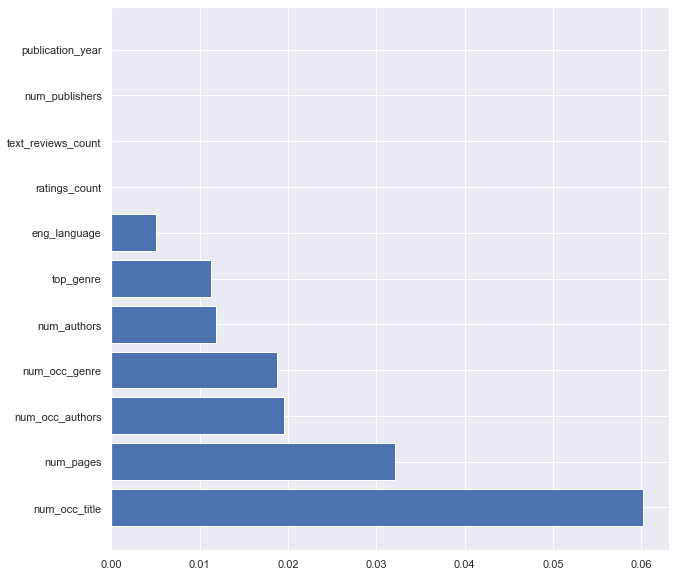

In [302]:
scores = make_mi_scores(X,y)

plt.figure(figsize=(10,10))
plt.barh(y=scores.index,width=scores)
plt.show()

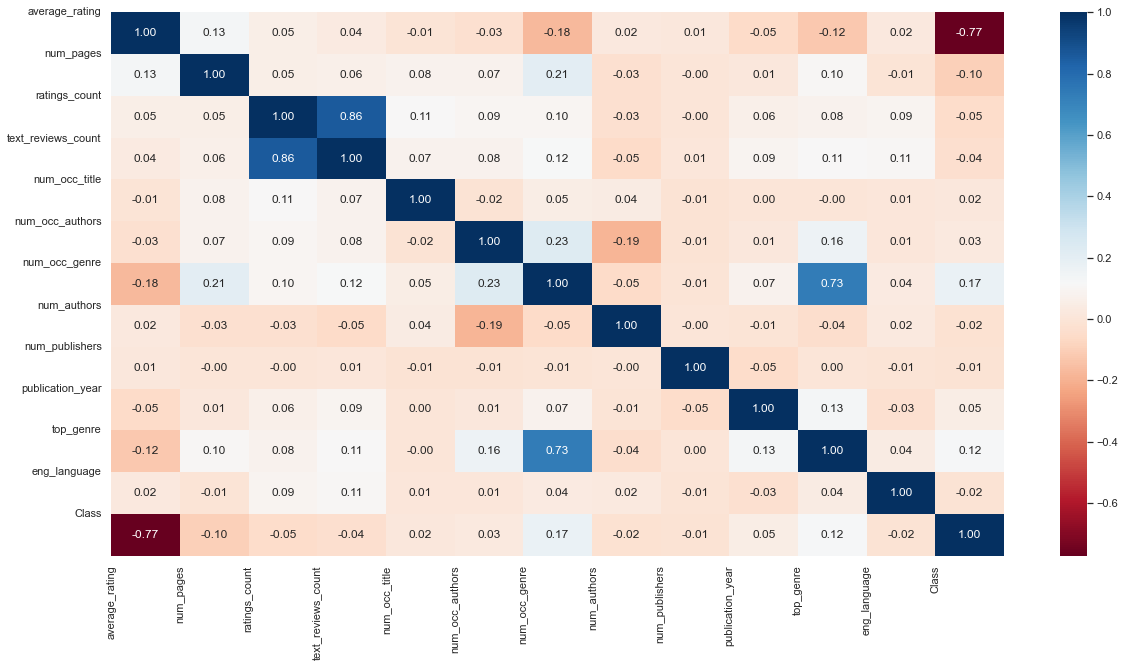

In [303]:
corr = books_df_processed.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

The results from MI and correlation are quite opposite on the number of occurences of a title and the ratings count. However, both computationally agree that the top genre , the number of occurences of a genre and the number of pages have an influence on the average rating, the 2 first being anti-correlated and the last being positive-correlated. They also agree that **eng_language** and **num_publishers** have the weakest dependencies to our targets. So we can get rid of them

In [304]:
books_df_processed.drop(columns=['eng_language', 'num_publishers'],inplace = True)

# D - Machine Learning

## D1 - Preprocessing

In [305]:
from sklearn.model_selection import train_test_split

books_df_train, books_df_test = train_test_split(books_df_processed,test_size = 0.2, random_state=42)

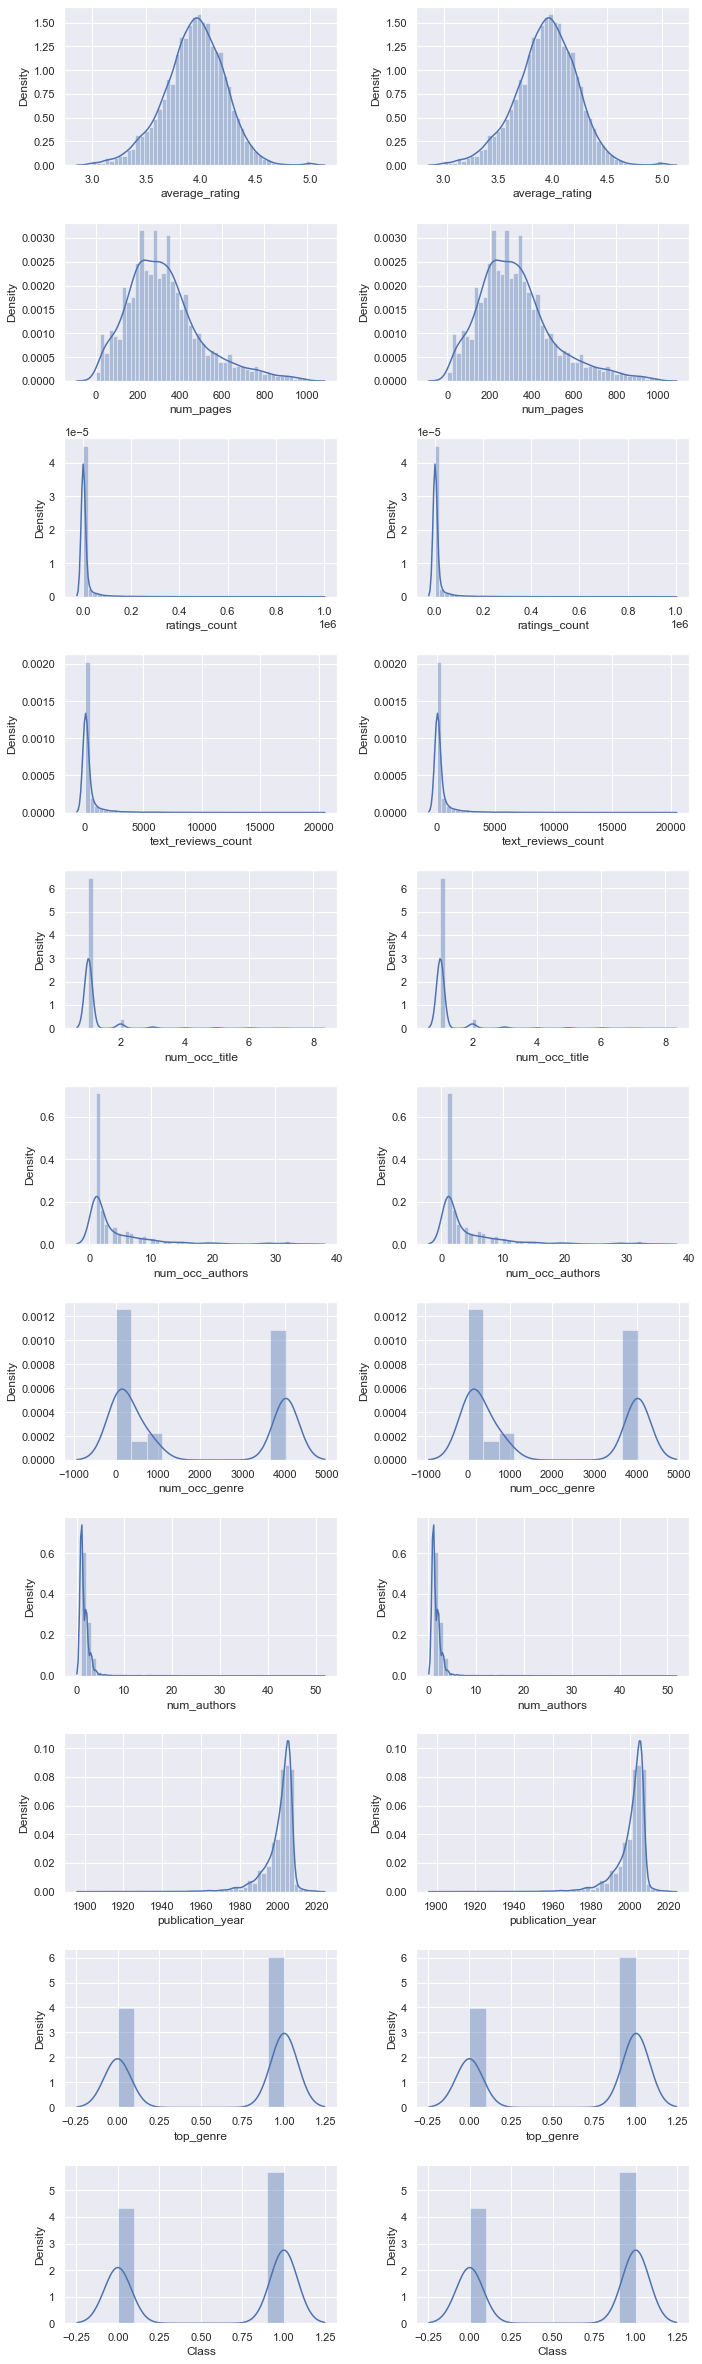

In [306]:
cols = books_df_processed.columns.tolist()
fig, ax = plt.subplots(nrows=len(cols),ncols=2,figsize=(10,3*len(cols)))
for i,col in enumerate(cols):
    current_ax_train = ax[i][0]
    current_ax_test = ax[i][1]

    sns.distplot(books_df_train[col],ax=current_ax_train)
    sns.distplot(books_df_train[col],ax=current_ax_test)

fig.tight_layout()
plt.show()

The split has not modified the distribution of the variables. So we can proceed with the target and feature variables identificaiton

In [307]:
target_col_1 = 'average_rating'
target_col_2 = 'Class'
feature_cols = [col for col in cols if col not in [target_col_1, target_col_2]]
print(feature_cols)

['num_pages', 'ratings_count', 'text_reviews_count', 'num_occ_title', 'num_occ_authors', 'num_occ_genre', 'num_authors', 'publication_year', 'top_genre']


In [308]:
X_train = books_df_train[feature_cols].values
Y_train = books_df_train[target_col_1].values.reshape(-1,1)
Z_train = books_df_train[target_col_2].values.reshape(-1,1)

X_test = books_df_test[feature_cols].values
Y_test = books_df_test[target_col_1].values.reshape(-1,1)
Z_test = books_df_test[target_col_2].values.reshape(-1,1)

print(X_train.shape)
print(Y_train.shape)
print(Z_train.shape)

(7955, 9)
(7955, 1)
(7955, 1)


In [309]:
# Scale the data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()


X_train = scaler_std.fit_transform(X_train)
X_train = scaler_minmax.fit_transform(X_train)

X_test = scaler_std.fit_transform(X_test)
X_test = scaler_minmax.fit_transform(X_test)

## D2 - Training as a regression problem

For each presented model, the parameters used were found through a Grid Search + Cross validation method. Due to its high computational time, we decided not to insert it in this notebook. If one has the need to use it, he/she should be free to be inspired by the lines below:

**Example of finetuning with the GridSearch function: Case of the Multi-Perceptron Layer model**

#Set the scoring method and the K-folds for cross validation  
scoring_regression = 'neg_root_mean_squared_error'  
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)  

#Instantiate the model and the various set of parameters for grid search  
model = MLPRegressor(max_iter = 500)  
parameters = {  
    'hidden_layer_sizes': [(1,), (50,)],  
    'learning_rate_init': [0.001, 0.005, 0.01, 0.05],  
    'momentum': [0, 0.33, 0.66, 1],  
    'solver': ["lbfgs", "sgd", "adam"],  
    'activation': ["identity", "logistic", "tanh", "relu"],  
    'alpha': [0.00005,0.0005,0.0001]  
}  

#Perform grid search and fit the best model with the training set   
grad_nn = GridSearchCV(model, parameters, scoring = scoring_regression, cv = cv, refit = True)  
grad_nn.fit(X_train, Y_train.ravel())  

#To access to the best score, the best tuning parameters and optimized models  
print('Best Score: ', grad_nn.best_score_, '\nBest Parameters: ', grad_nn.best_params_)  
print(grad_nn.best_estimator_)  


In [310]:
# Import and define elements necessary for metrics computation
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
import eli5
from eli5.sklearn import PermutationImportance

### 1 - Linear regression

In [311]:
from sklearn.linear_model import LinearRegression

grad_linear_reg = LinearRegression(fit_intercept=True)
grad_linear_reg.fit(X_train, Y_train)

# Predicted values
pred_linear_reg = grad_linear_reg.predict(X_test) # on test set
pred_linear_reg_train = grad_linear_reg.predict(X_train) # on train set

# Get the permutation importance of features
perm_linear = PermutationImportance(grad_linear_reg, random_state=1).fit(X_test, Y_test)

### 2 - Polynomial Regression

In [312]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Fit the model
poly_features = PolynomialFeatures(degree = 2)
X_train_poly = poly_features.fit_transform(X_train)
polynomial_regressor = LinearRegression()
polynomial_regressor.fit(X_train_poly, Y_train)

# Predicted values
X_test_poly = poly_features.fit_transform(X_test)
pred_poly_reg = polynomial_regressor.predict(X_test_poly)
pred_poly_reg_train = polynomial_regressor.predict(X_train_poly)

# Get the permutation importance of features
perm_poly = PermutationImportance(polynomial_regressor, random_state=1).fit(X_test_poly, Y_test)

### 3 - Ridge Regression

In [313]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures 

# Fit the model                   
poly_features_ridge = PolynomialFeatures(degree = 2)
X_train_poly = poly_features_ridge.fit_transform(X_train)
grad_ridge_reg = Ridge(fit_intercept = True, alpha = 5, max_iter=3000)
grad_ridge_reg.fit(X_train_poly, Y_train)

# Predicted values
X_test_poly = poly_features_ridge.fit_transform(X_test)
pred_ridge_reg = grad_ridge_reg.predict(X_test_poly)
pred_ridge_reg_train = grad_ridge_reg.predict(X_train_poly)

# Get the permutation importance of features
perm_ridge = PermutationImportance(grad_ridge_reg, random_state=1).fit(X_test_poly, Y_test)

### 4 - Lasso Regression

In [314]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

# Fit the model
poly_features_lasso = PolynomialFeatures(degree = 2)
X_train_poly = poly_features_lasso.fit_transform(X_train)
grad_lasso_reg = Lasso(fit_intercept = False, alpha = 0.005, max_iter=3000)
grad_lasso_reg.fit(X_train_poly, Y_train)

# Predicted values
X_test_poly = poly_features_lasso.fit_transform(X_test)
pred_lasso_reg = grad_lasso_reg.predict(X_test_poly)
pred_lasso_reg_train = grad_lasso_reg.predict(X_train_poly)

# Get the permutation importance of features
perm_lasso = PermutationImportance(grad_lasso_reg, random_state=1).fit(X_test_poly, Y_test)

### 5 - Adaboost and Decision tree regression

In [315]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

grad_Ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), learning_rate = 0.01, n_estimators=100, random_state=1)

grad_Ada.fit(X_train, Y_train.ravel())

# Predicted values
pred_adaboost = grad_Ada.predict(X_test)
pred_adaboost_train = grad_Ada.predict(X_train)

# Get the permutation importance of features
perm_adaboost = PermutationImportance(grad_Ada, random_state=1).fit(X_test, Y_test.ravel())

### 6 - Random Forest Regression

In [316]:
from sklearn.ensemble import RandomForestRegressor

grad_random_reg = RandomForestRegressor(max_depth = 15, min_samples_leaf = 5, min_samples_split = 10, n_estimators = 150)
grad_random_reg.fit(X_train,Y_train.ravel())

# Predicted values
pred_random_reg = grad_random_reg.predict(X_test)
pred_random_reg_train = grad_random_reg.predict(X_train)

# Get the permutation importance of features
perm_random = PermutationImportance(grad_random_reg, random_state=1).fit(X_test, Y_test.ravel())

### 7 - Neural Networks

In [317]:
from sklearn.neural_network import MLPRegressor

grad_nn = MLPRegressor(activation = 'relu', alpha = 5e-05, hidden_layer_sizes = (50,), 
                     learning_rate_init = 0.1, momentum = 0.66, solver = 'lbfgs', max_iter=500)

grad_nn.fit(X_train, Y_train.ravel())

# Predicted values
pred_nn = grad_nn.predict(X_test)
pred_nn_train = grad_nn.predict(X_train)

# Get the permutation importance of features
perm_nn = PermutationImportance(grad_nn, random_state=1).fit(X_test, Y_test.ravel())

### 8 - Benchmark of regression models

We will compare the different models on two aspects :   
**1 - Visual aspect:** Which model gives the closest predicted values to the real ones    
**2 - Computational aspect:** Which model gives the best metrics

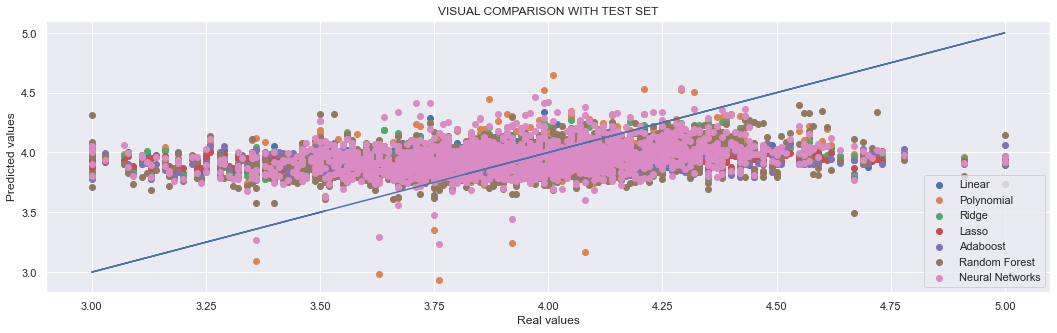

In [318]:
# The idea here is to plot the real values versus the prediction for the test data. 
# The more the points are aligned with the line y = x the better the prediction
plt.scatter(Y_test, pred_linear_reg, label = 'Linear')  
plt.scatter(Y_test, pred_poly_reg, label = 'Polynomial') 
plt.scatter(Y_test, pred_ridge_reg, label = 'Ridge') 
plt.scatter(Y_test, pred_lasso_reg, label = 'Lasso')
plt.scatter(Y_test, pred_adaboost, label =  'Adaboost') 
plt.scatter(Y_test, pred_random_reg, label = 'Random Forest')
plt.scatter(Y_test, pred_nn, label = 'Neural Networks')
plt.plot(Y_test,Y_test)
plt.title('VISUAL COMPARISON WITH TEST SET')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.legend(loc='lower right')
plt.show()

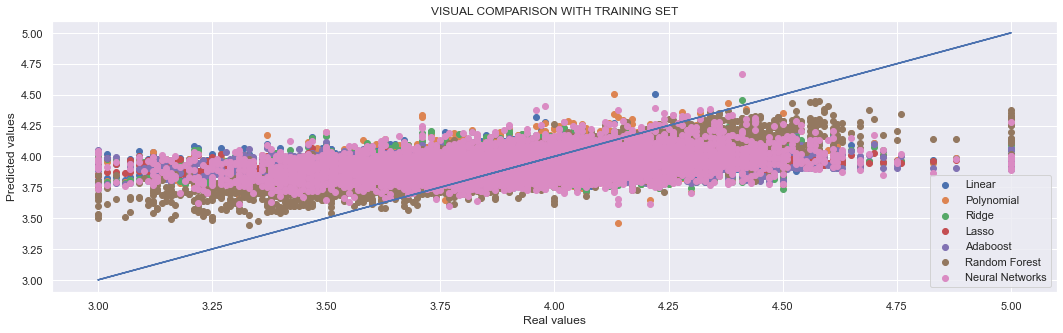

In [319]:
# The idea here is to plot the real values versus the prediction for the train data
plt.scatter(Y_train, pred_linear_reg_train, label = 'Linear')  
plt.scatter(Y_train, pred_poly_reg_train, label = 'Polynomial') 
plt.scatter(Y_train, pred_ridge_reg_train, label = 'Ridge') 
plt.scatter(Y_train, pred_lasso_reg_train, label = 'Lasso')
plt.scatter(Y_train, pred_adaboost_train, label =  'Adaboost') 
plt.scatter(Y_train, pred_random_reg_train, label = 'Random Forest')
plt.scatter(Y_train, pred_nn_train, label = 'Neural Networks')
plt.plot(Y_train,Y_train)
plt.title('VISUAL COMPARISON WITH TRAINING SET')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.legend(loc='lower right')
plt.show()

From the training data set, the Random Forest gives the prediction that has the closest values to the real ones. However, from the test data set, it's really hard to visually distinguish among the models's predicted values. Let's compare each model's metrics

In [320]:
# Summmarize each model's metrics in a table
pred_val_dict = {'Linear': pred_linear_reg,
                 'Polynomial': pred_poly_reg,
                 'Ridge': pred_ridge_reg,
                 'Lasso': pred_lasso_reg,
                 'Adaboost': pred_adaboost,
                 'Random Forest': pred_random_reg,
                 'Neural Networks': pred_nn}

metrics_reg = pd.DataFrame(index = pred_val_dict.keys(), columns = ['RSS', 'RMSE','R2 score', 'MAPE'])

for modelName in pred_val_dict.keys() :
    pred_val = pred_val_dict[modelName]
    metrics_reg['RSS'] [modelName]= np.mean((pred_val - Y_test) ** 2) # Residual sum of squares
    metrics_reg['RSS'] [modelName] = round(metrics_reg['RSS'] [modelName],4)
    
    metrics_reg['RMSE'][modelName] = np.sqrt(mean_squared_error(Y_test, pred_val)) # RMSE
    metrics_reg['RMSE'][modelName] = round(metrics_reg['RMSE'][modelName],3)
    
    metrics_reg['R2 score'][modelName] = np.sqrt(r2_score(Y_test, pred_val)) # R²
    metrics_reg['R2 score'][modelName] = round(metrics_reg['R2 score'][modelName],2)
    
    metrics_reg['MAPE'][modelName] = 100*mean_absolute_percentage_error(Y_test, pred_val) # Mean absolute percentage error
    metrics_reg['MAPE'][modelName] = round(metrics_reg['MAPE'][modelName],2)

metrics_reg

,RSS,RMSE,R2 score,MAPE
Linear,0.0764,0.276,0.25,5.57
Polynomial,0.0761,0.276,0.25,5.54
Ridge,0.0749,0.274,0.28,5.5
Lasso,0.0831,0.278,0.22,5.61
Adaboost,0.0879,0.273,0.29,5.45
Random Forest,0.0955,0.263,0.39,5.21
Neural Networks,0.096,0.275,0.26,5.54


As a reminder, a good regression model is the one that has the lowest RSS, RMSE and MAPE + the closest R² to 1. From our previous comparison table, the Random Forest model seems to be the best (even if the gap is pretty narrow for some of them)

## D3 - Training as a classification problem

In [321]:
from sklearn.metrics import classification_report, confusion_matrix
import eli5
from eli5.sklearn import PermutationImportance

### 1 - Logistic Classification

In [322]:
from sklearn.linear_model import LogisticRegression

grad_logis_class = LogisticRegression(fit_intercept = True, penalty = 'none', solver = 'newton-cg')
grad_logis_class.fit(X_train, Z_train.ravel())

# Validation of the model
pred_logis_class= grad_logis_class.predict(X_test)

# Get the permutation importance of features
perm_logis_class = PermutationImportance(grad_logis_class, random_state=1).fit(X_test, Z_test.ravel())

# Check Model metrics
report_logis_class = classification_report(y_pred=pred_logis_class,y_true=Z_test, output_dict = True)
  
cm = pd.DataFrame(
    confusion_matrix(
        Z_test,
        pred_logis_class,
        labels=[0,1]
    ),
    index = ['high ratings (real)','good ratings (real)'],
    columns = ['high ratings (pred)','good ratings (pred)']
)

cm["total"] = cm.sum(axis=1)
cm


,high ratings (pred),good ratings (pred),total
high ratings (real),353,540,893
good ratings (real),261,835,1096


### 2 - Adaboost and Decision Tree Classifiers

In [323]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

grad_Ada_class = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),
                                    learning_rate = 0.005, n_estimators  = 1000)

grad_Ada_class.fit(X_train, Z_train.ravel())

# Validation of the model
pred_ada_class= grad_Ada_class.predict(X_test)

# Get the permutation importance of features
perm_ada_class = PermutationImportance(grad_Ada_class, random_state=1).fit(X_test, Z_test.ravel())

# Check Model metrics
report_ada_class = classification_report(y_pred=pred_ada_class,y_true=Z_test,output_dict = True)

cm = pd.DataFrame(
    confusion_matrix(
        Z_test,
        pred_ada_class,
        labels=[0,1]
    ),
    index = ['high ratings (real)','good ratings (real)'],
    columns = ['high ratings (pred)','good ratings (pred)']
)


cm["total"] = cm.sum(axis=1)
cm

,high ratings (pred),good ratings (pred),total
high ratings (real),475,418,893
good ratings (real),298,798,1096


### 3 - Random Forest Classifier

In [324]:
from sklearn.ensemble import RandomForestClassifier

grad_random_class = RandomForestClassifier(max_depth = 12, min_samples_leaf = 5, min_samples_split = 5, n_estimators = 200)

grad_random_class.fit(X_train, Z_train.ravel())

# Validation of the model
pred_random_class= grad_random_class.predict(X_test)

# Get the permutation importance of features
perm_random_class = PermutationImportance(grad_random_class, random_state=1).fit(X_test, Z_test.ravel())

# Check Model metrics
report_random_class = classification_report(y_pred=pred_random_class,y_true=Z_test,output_dict = True)

cm = pd.DataFrame(
    confusion_matrix(
        Z_test,
        pred_random_class,
        labels=[0,1]
    ),
    index = ['high ratings (real)','good ratings (real)'],
    columns = ['high ratings (pred)','good ratings (pred)']
)


cm["total"] = cm.sum(axis=1)
cm

,high ratings (pred),good ratings (pred),total
high ratings (real),478,415,893
good ratings (real),286,810,1096


### 4 - Artificial Neural Networks

In [325]:
from sklearn.neural_network import MLPClassifier

grad_nn_class = MLPClassifier(activation = 'relu', alpha = 5e-05, hidden_layer_sizes = (50,), 
                              learning_rate_init = 0.1, momentum = 0.66, solver = 'lbfgs' , max_iter=500)

grad_nn_class.fit(X_train, Z_train.ravel())

# Validation of the model
pred_nn_class= grad_nn_class.predict(X_test)

# Get the permutation importance of features
perm_nn_class = PermutationImportance(grad_nn_class, random_state=1).fit(X_test, Z_test.ravel())

# Check Model metrics
report_nn_class = classification_report(y_pred=pred_nn_class,y_true=Z_test,output_dict = True)

cm = pd.DataFrame(
    confusion_matrix(
        Z_test,
        pred_nn_class,
        labels=[0,1]
    ),
    index = ['high ratings (real)','good ratings (real)'],
    columns = ['high ratings (pred)','good ratings (pred)']
)


cm["total"] = cm.sum(axis=1)
cm

,high ratings (pred),good ratings (pred),total
high ratings (real),473,420,893
good ratings (real),336,760,1096


### 5 - Benchmark of classification models

In the context of classification approach and our real-world problem, we judge a model by its ability of classifying books with good ratings. Otherwise, any overestimation could lead to a reader being unsatisfied by a book which he/she expected to be of high quality. Thus, the best model will be selected firstly based on its precision on books having good ratings. Afterwards, other metrics such as recall and accuracy would be looked at (in case, two or more models have the same precision values for instance)  
As a reminder, *label 0* is for high-rated books and *label 1* for well-rated books

In [326]:
# Summmarize each model's metrics in a table
report_class_dict = {'Logistic': report_logis_class,
                     'Adaboost': report_ada_class,
                     'Random Forest': report_random_class,
                     'Neural Networks': report_nn_class}

metrics_class = pd.DataFrame(index = report_class_dict.keys(), 
                       columns = ['precision_good_ratings', 'recall_good_ratings',
                                  'precision_high_ratings', 'recall_high_ratings','accuracy'])

for modelName in report_class_dict.keys() :
    report_class = report_class_dict[modelName]
    metrics_class['precision_good_ratings'] [modelName]= 100*report_class['1']['precision']
    metrics_class['precision_good_ratings'] [modelName] = round(metrics_class['precision_good_ratings'] [modelName],2)
    
    metrics_class['recall_good_ratings'] [modelName]= 100*report_class['1']['recall']
    metrics_class['recall_good_ratings'] [modelName] = round(metrics_class['recall_good_ratings'] [modelName],2)
    
    metrics_class['precision_high_ratings'] [modelName]= 100*report_class['0']['precision']
    metrics_class['precision_high_ratings'] [modelName] = round(metrics_class['precision_high_ratings'] [modelName],2)
    
    metrics_class['recall_high_ratings'] [modelName]= 100*report_class['0']['recall']
    metrics_class['recall_high_ratings'] [modelName] = round(metrics_class['recall_high_ratings'] [modelName],2)
    
    metrics_class['accuracy'] [modelName]= 100*report_class['accuracy']
    metrics_class['accuracy'] [modelName] = round(metrics_class['accuracy'] [modelName],2)

metrics_class

,precision_good_ratings,recall_good_ratings,precision_high_ratings,recall_high_ratings,accuracy
Logistic,60.73,76.19,57.49,39.53,59.73
Adaboost,65.62,72.81,61.45,53.19,64.0
Random Forest,66.12,73.91,62.57,53.53,64.76
Neural Networks,64.41,69.34,58.47,52.97,61.99


Random Forest is again the best model to predict the books ratings

# E - Conclusions and discussions

In [327]:
# Regression Models
best_model = 'Random Forest' # change the value here

perm_dict = {'Linear': perm_linear,
             'Polynomial': perm_poly,
             'Ridge': perm_ridge,
             'Lasso': perm_lasso,
             'Adaboost': perm_adaboost,
             'Random Forest': perm_random,
             'Neural Networks': perm_nn}

poly_features_dict = {'Polynomial': poly_features,
                   'Ridge': poly_features_ridge,
                   'Lasso': poly_features_lasso}

perm_chosen = perm_dict[best_model]

if best_model not in poly_features_dict.keys():
    display(eli5.show_weights(perm_chosen, feature_names = feature_cols))
else:
    feature_cols_1 = {}
    for i in range(len(feature_cols)):
        feature_cols_1['x'+str(i)] = feature_cols[i]  
    
    print(feature_cols_1)
    
    poly_features_chosen = poly_features_dict[best_model]
    display(eli5.show_weights(perm_chosen, feature_names = poly_features_chosen.get_feature_names()))

Weight,Feature
0.2888 ± 0.0192,ratings_count
0.1647 ± 0.0413,num_occ_genre
0.1444 ± 0.0206,text_reviews_count
0.1312 ± 0.0127,num_pages
0.0312 ± 0.0076,num_occ_authors
0.0262 ± 0.0094,publication_year
0.0209 ± 0.0120,num_authors
0.0029 ± 0.0014,num_occ_title
0.0009 ± 0.0008,top_genre


The Random Forest in Regression gives its greatest importance to the number of ratings. Other features have much weights to the ratings such as the number of text reviews, the number of pages or the popularity of a genre in the bookshelves. 

In [328]:
best_model = 'Random Forest' # change the value here

perm_dict = {'Linear': perm_logis_class,
             'Adaboost': perm_ada_class,
             'Random Forest': perm_random_class,
             'Neural Networks': perm_nn_class}


perm_chosen = perm_dict[best_model]

display(eli5.show_weights(perm_chosen, feature_names = feature_cols))

Weight,Feature
0.0647 ± 0.0197,num_occ_genre
0.0580 ± 0.0228,ratings_count
0.0509 ± 0.0077,num_pages
0.0211 ± 0.0080,text_reviews_count
0.0131 ± 0.0109,num_occ_authors
0.0039 ± 0.0079,publication_year
0.0019 ± 0.0012,num_authors
-0.0007 ± 0.0087,top_genre
-0.0030 ± 0.0011,num_occ_title


The Random Forest in classification acknowledges the same most important features as in regression. Note that the order of importance is not the same between the 2 approaches.   
It remains clear that the higher the count of ratings and text reviews a book has, the better the ratings it will receive. In fact, this generally happen for popular books that have been well-critized. The same trend can also be viewed on the number of pages. Precisely, books with high number of pages are seen by readers as rich and full of substance which impacts positively their ratings. Finally, it’s obvious that popular genres are appreciated by the public and therefore any book categorized in a popular genre has high odds to be well-criticized by the readers